In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


class PortfolioABTest:
    """
    A class to perform A/B testing on portfolio allocation strategies using rolling returns.

    Parameters
    ----------
    file_path : str
        Path to CSV file with daily prices (Date column + equity symbols).
    weights_a : dict
        Weights for A strategy (e.g., {'AAPL': 0.5, 'MSFT': 0.3, 'GOOGL': 0.2}).
    weights_b : dict
        Weights for B strategy (e.g., {'AAPL': 0.2, 'MSFT': 0.3, 'GOOGL': 0.5}).
    window : int, optional
        Rolling window size in days (default is 30).
    investment : float, optional
        Initial investment amount in dollars (default is 1,000,000).
    """

    def __init__(self, file_path, weights_a, weights_b, window=30, investment=1000000):
        self.file_path = file_path
        self.weights_a = pd.Series(weights_a, name='Control')
        self.weights_b = pd.Series(weights_b, name='Treatment')
        self.window = window
        self.investment = investment
        self.returns = None
        self.portfolio_a = None
        self.portfolio_b = None
        self.rolling_a = None
        self.rolling_b = None
        self._load_and_process_data()

    def _load_and_process_data(self):
        """Load CSV data, calculate returns, and compute portfolio performance."""
        try:
            data = pd.read_csv(self.file_path, index_col='Date', parse_dates=True)
            if data.empty or len(data.columns) < 1:
                raise ValueError("CSV file is empty or missing equity columns")
        except FileNotFoundError:
            raise FileNotFoundError(f"CSV file not found: {self.file_path}")
        except Exception as e:
            raise ValueError(f"Error loading CSV: {str(e)}")

        # Calculate daily returns
        self.returns = data.pct_change().dropna()
        symbols = self.returns.columns.tolist()

        # Validate weights
        for weights, name in [(self.weights_a, 'Control'), (self.weights_b, 'Treatment')]:
            if set(weights.index) != set(symbols):
                raise ValueError(f"{name} weights must match CSV symbols: {symbols}")
            if not np.isclose(weights.sum(), 1.0, atol=1e-6):
                raise ValueError(f"{name} weights must sum to 1, got {weights.sum()}")

        # Compute portfolio returns
        self.portfolio_a = self.returns.dot(self.weights_a)
        self.portfolio_b = self.returns.dot(self.weights_b)

        # Compute rolling mean returns
        self.rolling_a = self.portfolio_a.rolling(window=self.window).mean().dropna()
        self.rolling_b = self.portfolio_b.rolling(window=self.window).mean().dropna()

    def statistical_test(self):
        """
        Perform a t-test on rolling returns.

        Returns
        -------
        tuple
            (t_statistic, p_value)
        """
        t_stat, p_value = stats.ttest_ind(self.rolling_a, self.rolling_b, equal_var=False)
        return t_stat, p_value

    def summary(self):
        """
        Summarize performance metrics.

        Returns
        -------
        pd.DataFrame
            Metrics for both strategies (mean, std, total gain).
        """
        days = len(self.returns)
        metrics = {
            'Mean Rolling Return': [self.rolling_a.mean(), self.rolling_b.mean()],
            'Std Dev Rolling Return': [self.rolling_a.std(), self.rolling_b.std()],
            'Total Gain ($)': [
                self.investment * (1 + self.portfolio_a.mean()) ** days - self.investment,
                self.investment * (1 + self.portfolio_b.mean()) ** days - self.investment
            ]
        }
        return pd.DataFrame(metrics, index=['Strategy (A)', 'Strategy (B)'])

    def plot_rolling_returns(self):
        """Plot rolling mean returns over time."""
        plt.figure(figsize=(12, 6))
        self.rolling_a.plot(label='Strategy (A)', color='blue')
        self.rolling_b.plot(label='Strategy (B)', color='green')
        plt.title(f'{self.window}-Day Rolling Mean Returns')
        plt.ylabel('Rolling Mean Return')
        plt.xlabel('Date')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_boxplot(self):
        """Plot boxplot of rolling returns."""
        plt.figure(figsize=(10, 6))
        plt.boxplot([self.rolling_a, self.rolling_b], tick_labels=['Strategy (A)', 'Strategy (B)'])
        plt.ylabel(f'{self.window}-Day Rolling Mean Return')
        plt.title('A/B Test: Rolling Returns Distribution')
        plt.grid(True)
        for i, returns in enumerate([self.rolling_a, self.rolling_b], 1):
            plt.text(i, returns.mean(), f"{returns.mean():.4f}", ha='center', va='bottom')
        plt.show()

    def plot_cumulative_returns(self):
        """Plot cumulative returns over time."""
        cumulative_a = (1 + self.portfolio_a).cumprod() - 1
        cumulative_b = (1 + self.portfolio_b).cumprod() - 1
        plt.figure(figsize=(12, 6))
        cumulative_a.plot(label='Strategy (A)', color='blue')
        cumulative_b.plot(label='Strategy (B)', color='green')
        plt.title('Cumulative Returns Over Time')
        plt.ylabel('Cumulative Return')
        plt.xlabel('Date')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run_test(self, alpha=0.05):
        """
        Run the full A/B test and print results.

        Parameters
        ----------
        alpha : float, optional
            Significance level (default is 0.05).
        """
        summary_df = self.summary()
        t_stat, p_value = self.statistical_test()

        print("A/B Test Results:")
        print(summary_df.to_string(formatters={
            'Mean Rolling Return': '{:.4f}'.format,
            'Std Dev Rolling Return': '{:.4f}'.format,
            'Total Gain ($)': '${:,.2f}'.format
        }))
        print(f"\nt-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
        if p_value < alpha:
            print(f"Reject the null hypothesis at alpha={alpha}: Significant difference in returns.")
        else:
            print(f"Fail to reject the null hypothesis at alpha={alpha}: No significant difference.")

        self.plot_boxplot()
        self.plot_rolling_returns()
        self.plot_cumulative_returns()

A/B Test Results:
             Mean Rolling Return Std Dev Rolling Return Total Gain ($)
Strategy (A)              0.0010                 0.0027 $10,990,446.82
Strategy (B)              0.0010                 0.0029 $10,254,179.57

t-statistic: -0.4420, p-value: 0.6585
Fail to reject the null hypothesis at alpha=0.05: No significant difference.


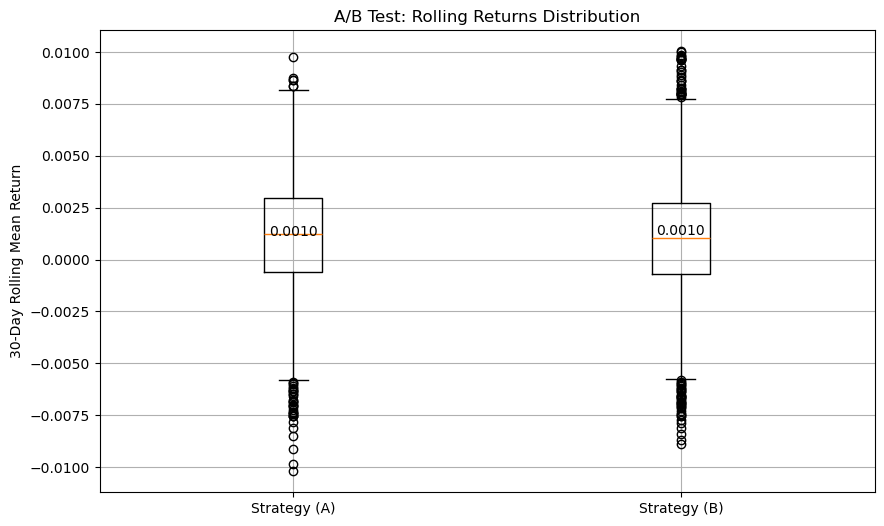

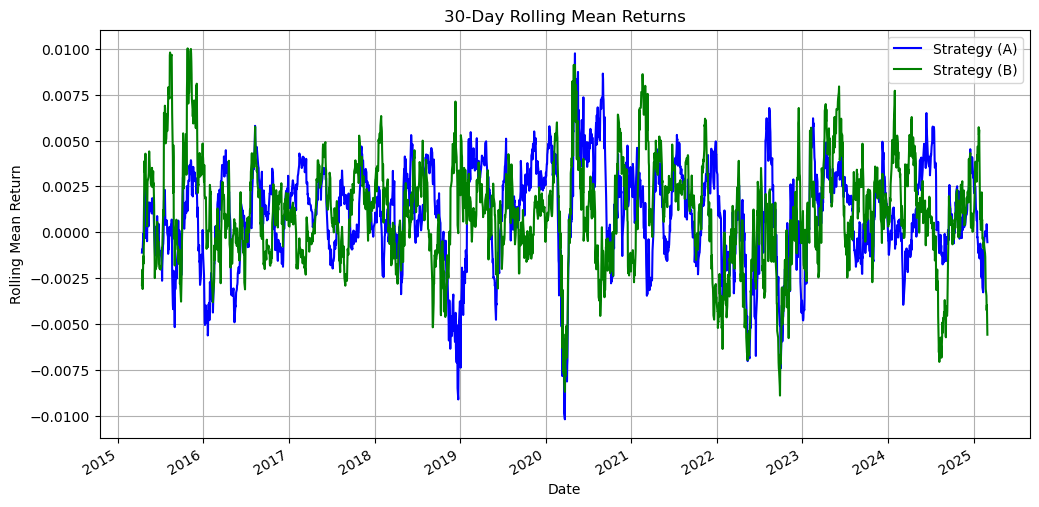

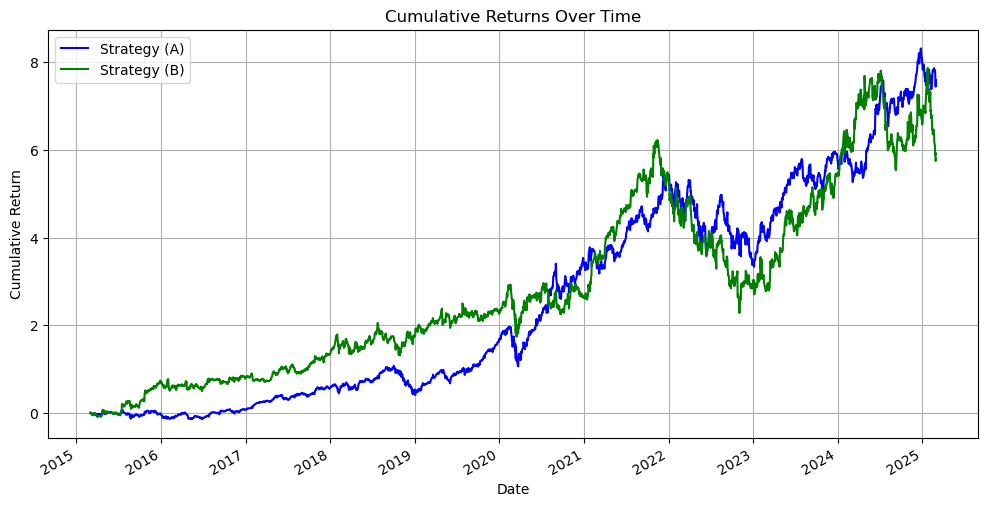

In [12]:
# Example usage

# Define weights for a 3-symbol portfolio
weights_a = {'AAPL': 0.7, 'MSFT': 0.1, 'GOOG': 0.2}  # Conservative
weights_b = {'AAPL': -0.6, 'MSFT': 0.8, 'GOOG': 0.8}  # Aggressive

# Initialize and run test
test = PortfolioABTest(
    file_path="/Users/spas/Working/portfolio.csv",
    weights_a=weights_a,
    weights_b=weights_b,
    window=30,
    investment=1000000
)
test.run_test()